# Training with fast.ai and TIMM
This Jupyter notebook shows how to load clean datasets from `vl-dataset` into [fastai](https://github.com/fastai/fastai) TIMM for training.

<!--<badge>--><a href="https://colab.research.google.com/github/visual-layer/vl-datasets/blob/main/notebooks/train-fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->
<!--<badge>--><a href="https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/vl-datasets/blob/main/notebooks/train-fastai.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a><!--</badge>-->

## Installation & Setting Up

In [1]:
!pip install vl-datasets fastai timm -Uqq

In [2]:
import vl_datasets
vl_datasets.__version__

'0.0.6'

## Download the Oxford-IIIT Pet Dataset

The Oxford-IIIT Pet Dataset is a highly curated computer vision dataset.
It contains 37 categories of pets with ~200 images for each class.

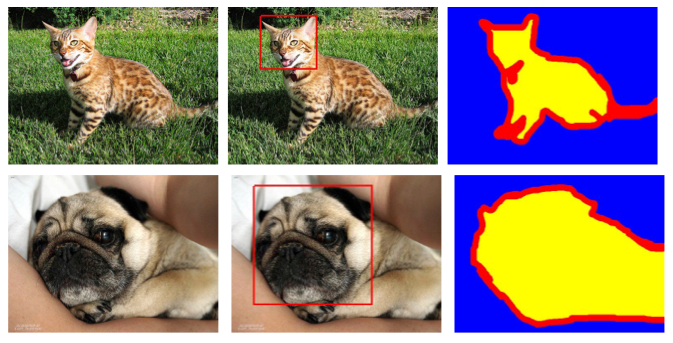

Using `vl-datasets`, you can conveniently get the clean version of the dataset.

In [3]:
from vl_datasets import CleanOxfordIIITPet

train_dataset = CleanOxfordIIITPet('./', split='trainval')
valid_dataset = CleanOxfordIIITPet('./', split='test')

Apply default transform
Excluded Abyssinian_114 from the trainval set
Excluded beagle_142 from the trainval set
Excluded Bengal_105 from the trainval set
Excluded Bengal_131 from the trainval set
Excluded Bombay_132 from the trainval set
Excluded Bombay_139 from the trainval set
Excluded Abyssinian_177 from the trainval set
Excluded Abyssinian_18 from the trainval set
Excluded Bombay_150 from the trainval set
Excluded Bombay_157 from the trainval set
Excluded Bombay_177 from the trainval set
Excluded Bombay_191 from the trainval set
Excluded Bombay_19 from the trainval set
Excluded german_shorthaired_173 from the trainval set
Excluded keeshond_162 from the trainval set
Excluded keeshond_167 from the trainval set
Excluded keeshond_170 from the trainval set
Excluded leonberger_187 from the trainval set
Excluded Ragdoll_161 from the trainval set
Excluded saint_bernard_158 from the trainval set
Excluded yorkshire_terrier_180 from the trainval set
Excluded yorkshire_terrier_182 from the tra

The above code downloads the dataset and loads it as a Torchvision [`Datasets`](https://pytorch.org/vision/stable/datasets.html) object.

## Constructing DataLoaders

To use the dataset in a training framework, we need to construct a `DataLoader` out of the `Datasets` object.

We can conveniently do that with PyTorch's `DataLoader` module.

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

With the dataloaders set in place you can conveniently use them in a PyTorch training loop as shown in another notebook [here](./train-pytorch.ipynb).

To use the PyTorch `Dataloader`in fastai, we need to convert to fastai [`DataLoader`](https://fastai.github.io/fastai-docs/data.load) object.

In [5]:
from fastai.data.core import DataLoaders
dls = DataLoaders(train_loader, valid_loader)

## Import Modules

The `fastai.vision.all` module contains all the classes and functions for computer vision tasks in the fastai library. 

You can conveniently import all of the modules with:

In [6]:
from fastai.vision.all import *

## Define a Model in TIMM

The [pytorch-image-models (TIMM)](https://github.com/huggingface/pytorch-image-models) package by Hugging Face provides hundreds of state-of-the-art pretrained computer vision models.

We can easily use and leverage these models in our training to avoid training from scratch.

Using the `timm` package let's list the models that matches the wildcard 'resnet'.

In [7]:
import timm
timm.list_models("*resnet*")

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'gcresnet33ts',
 'gcresnet50t',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet101',
 'resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'r

As shown above there's many resnet variations available in `timm`.

For the sake of this example, let's pick a relatively simple model `resnet18` and instantiate it.

In [8]:
model = timm.create_model('resnet18', pretrained=True)

## Training in fastai

Now, load the model into fastai's [`Learner`](https://docs.fast.ai/learner.html#learner) which bind together a model, dataloaders, loss function, and metric for training.

In [9]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy).to_fp16()

One of fastai's distinctive feature is the ability to find an optimal learning rate for training the model.

SuggestedLRs(valley=0.00363078061491251)

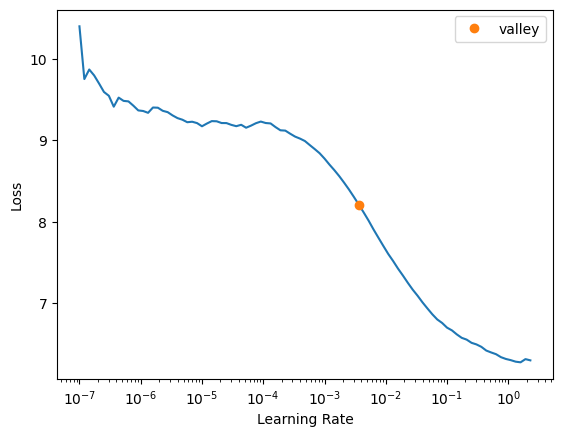

In [10]:
learn.lr_find()

Using the optimal learning rate of approximately `2e-3` let's fine tune the `resnet18` model.

epoch,train_loss,valid_loss,accuracy,time
0,4.019043,2.298470,0.633406,00:23


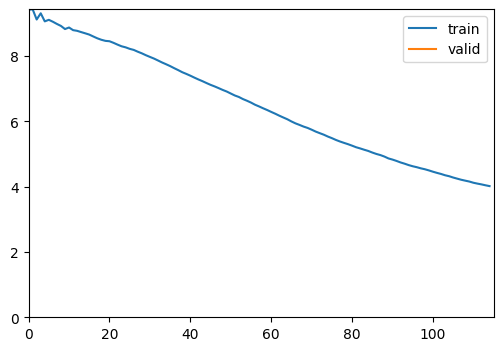

epoch,train_loss,valid_loss,accuracy,time
0,2.227736,1.643665,0.853198,00:23
1,2.049133,1.505790,0.893384,00:22
2,1.873231,1.355780,0.937124,00:23
3,1.740781,1.278495,0.963641,00:23
4,1.637288,1.257875,0.966102,00:23


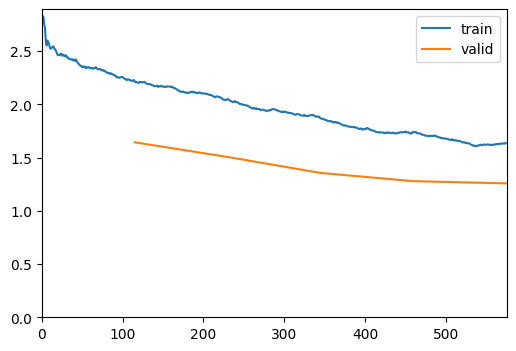

In [11]:
learn.fine_tune(5, base_lr=2e-3, cbs=[ShowGraphCallback()])

With just a few training epochs and under 3 minutes we have an accuracy over 95%. Not too bad.

## Evaluate Results
Once of the ways to learn about the performance of your model is to evaluate it on the validation set. For classification tasks it's easy to use confusion matrix to gauge the model performance.

In [15]:
learn.validate(dl=dls.valid)

(#2) [1.2578742504119873,0.9661017060279846]

Looks like we got an accuracy of 96.61% on the validatation dataset.

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Export the Trained Model

The export method is used to save the model to a file with the specified path and name. This trained model can be loaded later for inference or further fine-tuning.

In [16]:
learn = learn.to_fp32()
learn.save('my-resnet18-model', with_opt=False)

Path('models/my-resnet18-model.pth')

That's it! This notebook shows how to train a TIMM model using `fastai` with a pretrained architecture from `timm`. By following the steps in this notebook, you can easily train any models on `timm` on image datasets loaded with `vl-datasets`.



